# Convolutional Neural Network (CNN) for Facial Expression Recognition
## Alex Lauro
## APMA 4990 - Intro to Data Science Industry

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from PIL import Image
from flask import Flask
import pickle
import seaborn
%matplotlib inline

In [2]:
def image_to_grayscale_pixel_values(filepath):
    """
    Converts an image given by *filepath* into a flattened array of pixel values.
    The image is converted to grayscale format so pixel values range from 0-255 
    (0 = black, 255 = white).
    
    Args:
    *filepath* - file path containing image
    
    Output:
    *flat_pixels_array* - flattened array of image pixels
    """
    
    # Convert image to 8-bit grayscale
    img = Image.open(filepath).convert('L')  
    #img.save('/Users/Alex/Desktop/greyscale.png')
    
    width, height = img.size
    # Convert image data to a list of integers
    pixels = list(img.getdata()) 
    # Convert that to 2D list (list of lists of integers)
    pixels = [pixels[offset:offset + width] for offset in range(0, width * height, width)]
    # Convert list of lists to flattened array
    pixels_array = np.asarray(pixels)
    flat_pixels_array = pixels_array.flatten()
    return flat_pixels_array

# Image Pre-Processing 

In [3]:
df = pd.read_csv("/Users/Alex/Desktop/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
# Format testing image pixels into array
train_data = df[df.Usage == "Training"]
train_pixel_values = train_data.pixels.str.split(" ").tolist()
train_pixel_values = pd.DataFrame(train_pixel_values, dtype=int)
images = train_pixel_values.values
images = images.astype(np.float)

In [5]:
# Find mean and standard deviation of training image pixels and then standardize
images = images - images.mean(axis=1).reshape(-1, 1)
images = np.multiply(images, 100.0 / 255.0)
pixel_mean = images.mean(axis=0)
pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images, pixel_mean), pixel_std)

In [6]:
# Find height and width of images
# Note this algorithm exploits the fact that the training images have equal height and width (i.e. 48x48)
image_height = np.ceil(np.sqrt(images.shape[1])).astype(int)
image_width = image_height

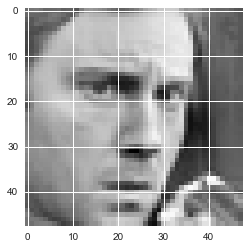

In [7]:
# Plot sample image
sample_image = images[0]
show_image = sample_image.reshape(image_width, image_height)
plt.imshow(show_image, cmap='gray')
plt.show()

In [8]:
emotions_flat = train_data["emotion"].values.ravel()
num_emotions = np.unique(emotions_flat).shape[0]

# Method for transforming an array into a one-hot matrix
#def array_to_one_hot(num_labels, target_array, dtype=int):
#    return np.eye(num_labels)[target_array]

def array_to_one_hot(emotions_dense, num_classes):
    num_labels = emotions_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    emotions_one_hot = np.zeros((num_labels, num_classes))
    emotions_one_hot.flat[index_offset + emotions_dense.ravel()] = 1
    return emotions_one_hot

emotions = array_to_one_hot(emotions_flat, num_emotions)
emotions = emotions.astype(np.uint8)

In [9]:
# Split data into training and validation sets
VALIDATION_PERCENT = 0.06
VALIDATION_SIZE = np.ceil(VALIDATION_PERCENT * images.shape[0]).astype(int)

validation_images = images[:VALIDATION_SIZE]
validation_labels = emotions[:VALIDATION_SIZE]
train_images = images[VALIDATION_SIZE:]
train_labels = emotions[VALIDATION_SIZE:]

In [10]:
print 'Size of training data set: %d' % train_images.shape[0]
print 'Size of validation data set: %d' % validation_images.shape[0]
print 'Total size: %d' % (validation_images.shape[0] + train_images.shape[0])

Size of training data set: 26986
Size of validation data set: 1723
Total size: 28709


# CNN Implementation 

In [11]:
K = 64 # First convolutional layer output depth
L = 128 # Second convolutional layer output depth
M = 3072 # Fully connected layer 1 depth

# Images
x = tf.placeholder('float', shape=[None, images.shape[1]])
# Emotion labels
y_ = tf.placeholder('float', shape=[None, num_emotions])

image = tf.reshape(x, [-1, image_width , image_height, 1])

In [12]:
# First convolutional layer with depth 64 and 5x5 filter size
w1 = tf.Variable(tf.truncated_normal([5, 5, 1, K], stddev=1e-4))
b1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))

conv1 = tf.nn.relu(tf.nn.conv2d(image, w1, strides=[1, 1, 1, 1], padding="SAME") + b1)
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

In [13]:
# Second convolutional layer with depth 128 and 5x5 filter size
w2 = tf.Variable(tf.truncated_normal([5, 5, 64, L], stddev=1e-4))
b2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))

conv2 = tf.nn.relu(tf.nn.conv2d(norm1, w2, strides=[1, 1, 1, 1], padding="SAME") + b2)
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

In [14]:
# Fully connected layer 1
w_fc1 = tf.Variable(tf.truncated_normal([12 * 12 * L, M], stddev=0.04))
b_fc1 = tf.Variable(tf.constant(0.0, tf.float32, [M]))

pool2_loc = tf.reshape(pool2, [-1, 12 * 12 * L])
h_fc1 = tf.nn.relu(tf.matmul(pool2_loc, w_fc1) + b_fc1)

In [15]:
# Fully connected layer 2
w_fc2 = tf.Variable(tf.truncated_normal([3072, 1536], stddev=0.04))
b_fc2 = tf.Variable(tf.constant(0.0, tf.float32, [1536]))

h_fc2_reshape = tf.reshape(h_fc1, [-1, 3072])
h_fc2 = tf.nn.relu(tf.matmul(h_fc2_reshape, w_fc2) + b_fc2)

In [16]:
# Dropout
keep_prob = tf.placeholder('float')
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

In [17]:
# Final fully connected layer feeding into softmax classifier
w_fc3 = tf.Variable(tf.truncated_normal([1536, num_emotions], stddev=0.04))
b_fc3 = tf.Variable(tf.constant(0.0, tf.float32, [num_emotions]))

y = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# Training CNN

In [18]:
# Optimization function parameter
LEARNING_RATE = 1e-4

# Cost function
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

# Optimization function minimizing cost function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# Evaluate accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# Prediction function
predict = tf.argmax(y, 1)

In [19]:
TRAINING_ITERATIONS = 3000
    
DROPOUT = 0.5
BATCH_SIZE = 50

In [20]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# Serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # When all trainig data have been already used, reorder randomly    
    if index_in_epoch > num_examples:
        # Finished epoch
        epochs_completed += 1
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [21]:
# Start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

In [22]:
# Variables to be printed 
train_accuracies = []
validation_accuracies = []
x_range = []

display_step = 1

In [23]:
for i in range(TRAINING_ITERATIONS):
    
    # Get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # Check progress on every 1st, 2nd, ..., 10th, 20th, ..., 100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict = {x:batch_xs, y_:batch_ys, keep_prob:1.0})               
        
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print 'training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i)
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print 'training_accuracy => %.4f for step %d'%(train_accuracy, i)
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # Increase display_step
        if i%(display_step*10) == 0 and i and display_step < 100:
            display_step *= 10
    
    # Train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})
    
    # Save final values of convolutional layer weights and biases
    val_w1 = sess.run(w1)
    val_w2 = sess.run(w2)
    
    val_b1 = sess.run(b1)
    val_b2 = sess.run(b2)
    
    val_w_fc1 = sess.run(w_fc1)
    val_w_fc2 = sess.run(w_fc2)
    val_w_fc3 = sess.run(w_fc3)
    
    val_b_fc1 = sess.run(b_fc1)
    val_b_fc2 = sess.run(b_fc2)
    val_b_fc3 = sess.run(b_fc3)

training_accuracy / validation_accuracy => 0.18 / 0.22 for step 0
training_accuracy / validation_accuracy => 0.36 / 0.24 for step 1
training_accuracy / validation_accuracy => 0.12 / 0.18 for step 2
training_accuracy / validation_accuracy => 0.18 / 0.22 for step 3
training_accuracy / validation_accuracy => 0.10 / 0.08 for step 4
training_accuracy / validation_accuracy => 0.18 / 0.24 for step 5
training_accuracy / validation_accuracy => 0.26 / 0.24 for step 6
training_accuracy / validation_accuracy => 0.22 / 0.24 for step 7
training_accuracy / validation_accuracy => 0.20 / 0.24 for step 8
training_accuracy / validation_accuracy => 0.16 / 0.18 for step 9
training_accuracy / validation_accuracy => 0.18 / 0.18 for step 10
training_accuracy / validation_accuracy => 0.08 / 0.10 for step 20
training_accuracy / validation_accuracy => 0.24 / 0.24 for step 30
training_accuracy / validation_accuracy => 0.26 / 0.24 for step 40
training_accuracy / validation_accuracy => 0.20 / 0.24 for step 50
train

Validation Accuracy: 0.5102


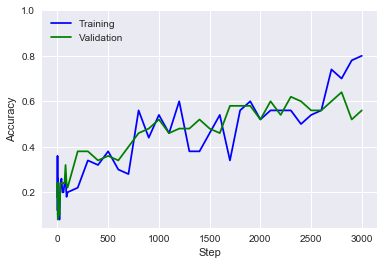

In [24]:
# Plot accuracy of training and validation sets
validation_accuracy = accuracy.eval(feed_dict={x: validation_images, y_: validation_labels, keep_prob: 1.0})
print 'Validation Accuracy: %.4f' % validation_accuracy
plt.plot(x_range, train_accuracies, '-b', label='Training')
plt.plot(x_range, validation_accuracies, '-g', label='Validation')
plt.legend(loc=2)
plt.ylim(ymax = 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.show()

# Testing CNN

In [25]:
import seaborn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

In [26]:
test_data = df[df.Usage == "PublicTest"]
test_data.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [27]:
print 'Number of testing images: %i' % len(test_data)

Number of testing images: 3589


In [28]:
# Format testing image pixels into array
test_pixel_values = test_data.pixels.str.split(" ").tolist()
test_pixel_values = pd.DataFrame(test_pixel_values, dtype=int)
test_images = test_pixel_values.values
test_images = test_images.astype(np.float)

In [29]:
# Standardization of image pixels
test_images = test_images - test_images.mean(axis=1).reshape(-1, 1)
test_images = np.multiply(test_images, 100.0 / 255.0)
test_images = np.divide(np.subtract(test_images, pixel_mean), pixel_std)

In [30]:
# Run CNN model on test images
predicted_labels = np.zeros(test_images.shape[0])

for i in range(0, test_images.shape[0] // BATCH_SIZE):
    predicted_labels[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], keep_prob: 1.0})

In [31]:
accuracy = accuracy_score(test_data.emotion.values, predicted_labels)
print 'Accuracy score: %.4f' % accuracy

Accuracy score: 0.5040


In [32]:
conf_matrix = confusion_matrix(test_data.emotion.values, predicted_labels)

def plot_confusion_matrix(cm, labels, normalize=False, cmap=plt.cm.Blues):
    """
    Plots the confusion matrix for test images.
    
    Args:
    *cm* - confusion matrix 2d array
    *labels* - array of emotion labels
    *normalize* - boolean value that normalizes matrix when normalize=True
    *cmap* - color map
    
    Output:
    Plots the confusion matrix for test images
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix for Test Images')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

Confusion matrix, without normalization
[[248   4  30  66  43  11  65]
 [ 20  18   1   6   5   1   5]
 [104   1 132  69  78  43  69]
 [ 87   0  19 660  50  15  64]
 [141   0  40 121 236  15 100]
 [ 41   1  42  35  17 251  28]
 [106   2  29 111  84  11 264]]


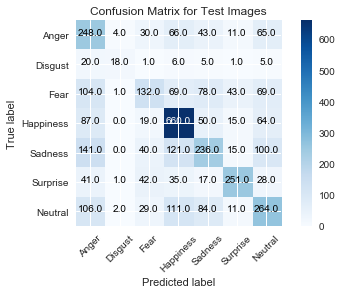

In [33]:
plot_confusion_matrix(conf_matrix, emotion_labels, normalize=False)
plt.show()

In [34]:
# Pickle weights and biases from trained CNN

fileObject1 = open("val_w1", 'wb')
pickle.dump(val_w1, fileObject1)
fileObject1.close()

fileObject2 = open("val_w2", 'wb')
pickle.dump(val_w2, fileObject2)
fileObject2.close()

fileObject3 = open("val_b1", 'wb')
pickle.dump(val_b1, fileObject3)
fileObject3.close()

fileObject4 = open("val_b2", 'wb')
pickle.dump(val_b2, fileObject4)
fileObject4.close()

fileObject5 = open("val_w_fc1", 'wb')
pickle.dump(val_w_fc1, fileObject5)
fileObject5.close()

fileObject6 = open("val_w_fc2", 'wb')
pickle.dump(val_w_fc2, fileObject6)
fileObject6.close()

fileObject7 = open("val_w_fc3", 'wb')
pickle.dump(val_w_fc3, fileObject7)
fileObject7.close()

fileObject8 = open("val_b_fc1", 'wb')
pickle.dump(val_b_fc1, fileObject8)
fileObject8.close()

fileObject9 = open("val_b_fc2", 'wb')
pickle.dump(val_b_fc2, fileObject9)
fileObject9.close()

fileObject10 = open("val_b_fc3", 'wb')
pickle.dump(val_b_fc3, fileObject10)
fileObject10.close()

# Also pickle mean and standard deviation of testing images
fileObject11 = open("pixel_mean", 'wb')
pickle.dump(pixel_mean, fileObject11)
fileObject11.close() 

fileObject12 = open("pixel_std", 'wb')
pickle.dump(pixel_std, fileObject12)
fileObject12.close() 